<a href="https://colab.research.google.com/github/neiluz/IT_Academy_ProyectoFinal/blob/main/Notebooks/Notebook%207.1%20Modelaje%20DL%20Clasificacion%20Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color: #1DA1F2; padding: 20px;"><b><h1> Descifrando el lenguaje emocional en Twitter: Un análisis predictivo basado en aprendizaje automático. </h1></b></div>

**Autor**: Neivys Luz González Gómez

La identificación de emociones es una tarea fundamental en el campo del procesamiento de lenguaje natural, que se enfoca en clasificar textos según su tono emocional. A pesar de que el objetivo es identificar una amplia variedad de emociones humanas, la mayoría de los conjuntos de datos disponibles se limitan a las polaridades positiva, negativa y, en ocasiones, neutral.

Detectar emociones a partir de textos es un reto complejo en el procesamiento del lenguaje natural, ya que se trata de un problema de clasificación multiclase y, en muchas ocasiones, no hay suficientes datos etiquetados disponibles. Sin embargo, este conjunto de datos etiquetado proporciona la oportunidad de aplicar diversas técnicas de análisis exploratorio y modelado para entender mejor la dinámica emocional en las redes sociales y mejorar la capacidad de detección en tiempo real.

El conjunto de datos de emociones se obtiene a partir de mensajes en inglés de Twitter y contiene seis emociones básicas: neutralidad, preocupación, felicidad, tristeza, amor, sorpresa, diversión, alivio, odio, vacío, entusiasmo y aburrimiento. Este conjunto de datos ofrece una variedad más amplia de emociones humanas, lo que permite el entrenamiento y la evaluación de modelos de análisis de sentimientos con mayor precisión y exhaustividad.

<div class="alert alert-info alert-info"><b><h3>Objetivo General</h3></b>
    
**Desarrollar un modelo que permita detectar emociones en los tweets y analizar patrones en el lenguaje utilizado en Twitter para ayudar en la detección temprana de trastornos emocionales como la depresión, la ansiedad, entre otros.**
</div>

---

# Notebook N° 7.1: Modelo Deep Learning con el modelo pre entrenado Bert - Clasificación Base

En este notebook se presenta la evaluación del modelo pre-entrenado Bert en la tarea de clasificación de sentimientos en tweets. Para ello, se utilizó un dataset preprocesado con las emociones originales.

El modelo implementado es un clasificador de texto basado en técnicas de aprendizaje profundo (deep learning) que utiliza el modelo pre-entrenado BERT para clasificar los tweets en tres categorías: positivo, negativo y neutral. BERT, acrónimo de Bidirectional Encoder Representations from Transformers, es un modelo de lenguaje basado en Transformers que fue pre-entrenado en enormes cantidades de datos textuales, lo que le permite capturar patrones complejos en el lenguaje. Al utilizar un modelo pre-entrenado como BERT, se pueden obtener mejores resultados con menos datos de entrenamiento y menos tiempo de entrenamiento. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

In [2]:
# general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

import warnings
warnings.filterwarnings('ignore')

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


---

<div class="alert alert-block alert-info">
<b><h2> Cargar Dataset.</h2></b> 
</div>

In [4]:
df = pd.read_pickle('/content/dataset1.pickle')

In [5]:
df

,content,sentiment_label
0,layin bed headache ughhhhwaitin call,9
1,funeral ceremonygloomy friday,9
2,want hang friend soon,2
3,want trade someone houston ticket one,7
4,repinging didnt go prom bc bf didnt like friend,11
...,...,...
38983,succesfully following tayla,4
38984,happy mother day love,6
38985,happy mother day mommy woman man long youre mo...,6
38986,wassup beautiful follow peep new hit single ww...,4


## 1. Preparación del Dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38988 entries, 0 to 38987
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          38988 non-null  object
 1   sentiment_label  38988 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 457.0+ KB


### 1.1 Verificar nulos y NaM

In [7]:
df.isnull().sum()

content            0
sentiment_label    0
dtype: int64

In [8]:
df.isna().sum()

content            0
sentiment_label    0
dtype: int64

* **Longitud del texto**

Se crea una columna para alojar la longitud del texto limpio

In [9]:
text_len = []
for text in df.content :
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [10]:
df['text_len'] = text_len

In [11]:
df.head()

,content,sentiment_label,text_len
0,layin bed headache ughhhhwaitin call,9,5
1,funeral ceremonygloomy friday,9,3
2,want hang friend soon,2,4
3,want trade someone houston ticket one,7,6
4,repinging didnt go prom bc bf didnt like friend,11,9


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38988 entries, 0 to 38987
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          38988 non-null  object
 1   sentiment_label  38988 non-null  int32 
 2   text_len         38988 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 761.6+ KB


### 1.3 Limpieza más profunda

Se realizará si se puede reañizar una limpieza adicional verificando la versión tokenizadora de las oraciones.

* **Primero, importar el tokenizador BERT.**

In [13]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [15]:
token_lens = []

for txt in df['content'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [16]:
print(f"Maxima logitud de las oraciones TOKENIZED: {max_len}")

Maxima logitud de las oraciones TOKENIZED: 61


In [17]:
df['token_lens'] = token_lens

In [18]:
df.head()

,content,sentiment_label,text_len,token_lens
0,layin bed headache ughhhhwaitin call,9,5,13
1,funeral ceremonygloomy friday,9,3,8
2,want hang friend soon,2,4,6
3,want trade someone houston ticket one,7,6,8
4,repinging didnt go prom bc bf didnt like friend,11,9,14


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38988 entries, 0 to 38987
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          38988 non-null  object
 1   sentiment_label  38988 non-null  int32 
 2   text_len         38988 non-null  int64 
 3   token_lens       38988 non-null  int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 1.0+ MB


<h3>Observaciones:</h3>

   *  Se puede observar que el data set no tiene valores nulos o NaN. 
   *  Se puede observar que el data set no tiene valores duplicados.  
   *  Al tokenizar el texto, se observa que aumentan la cantidad de palabras en la oracion o tweet.

## 2. Modelo

### 2.1 Se define el target y la feature

In [20]:
# Se define el target y la feature
X = df['content'].values
y = df['sentiment_label'].values

In [21]:
X.shape

(38988,)

In [22]:
y.shape

(38988,)

In [23]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [24]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (33139,)
X_test shape: (5849,)
y_train shape: (33139,)
y_test shape: (5849,)


In [25]:
# Dividir los datos de entrenamiento en entrenamiento y validación (70% - 15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [26]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

X_train shape: (28168,)
X_test shape: (5849,)
X_val shape: (4971,)
y_train shape: (28168,)
y_test shape: (5849,)
y_val shape: (4971,)


### 2.2 One hot encoding

In [27]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [28]:
print("Shape de y_train:", y_train_le.shape)
print("Shape de y_val:", y_valid_le.shape)
print("Shape de y_test:", y_test_le.shape)

Shape de y_train: (28168,)
Shape de y_val: (4971,)
Shape de y_test: (5849,)


In [29]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train_le).reshape(-1, 1)).toarray()
y_val = ohe.transform(np.array(y_valid_le).reshape(-1, 1)).toarray()
y_test = ohe.transform(np.array(y_test_le).reshape(-1, 1)).toarray()

In [30]:
print("Shape de y_train:", y_train.shape)
print("Shape de y_val:", y_val.shape)
print("Shape de y_test:", y_test.shape)

Shape de y_train: (28168, 12)
Shape de y_val: (4971, 12)
Shape de y_test: (5849, 12)


## 3.Modelo BERT

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de lenguaje basado en la arquitectura Transformer, que utiliza un enfoque bidireccional para el procesamiento de texto, lo que significa que considera el contexto completo de la oración en ambas direcciones para generar representaciones de palabras más precisas y contextualizadas.

El modelo BERT es pre-entrenado en grandes corpus de datos y luego se puede ajustar o fine-tunear para tareas específicas, como la clasificación de texto, la extracción de información o la generación de lenguaje natural. BERT ha establecido nuevos estándares de rendimiento en varias tareas de procesamiento de lenguaje natural y es ampliamente utilizado en la investigación y la industria.

### 3.1 Tokenizar el conjunto de datos

In [31]:
max_len = 128

In [32]:
def tokenize(data,max_lenmax_len) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

* Luego, aplica la función tokenizadora a los conjuntos de tren, validación y prueba.

In [33]:
train_input_ids, train_attention_masks = tokenize(X_train, max_len)
val_input_ids, val_attention_masks = tokenize(X_val, max_len)
test_input_ids, test_attention_masks = tokenize(X_test, max_len)

In [34]:
print("train_input_ids length:", len(train_input_ids))
print("train_attention_masks length:", len(train_attention_masks))
print("val_input_ids length:", len(val_input_ids))
print("val_attention_masks length:", len(val_attention_masks))
print("test_input_ids length:", len(test_input_ids))
print("test_attention_masks length:", len(test_attention_masks))

train_input_ids length: 28168
train_attention_masks length: 28168
val_input_ids length: 4971
val_attention_masks length: 4971
test_input_ids length: 5849
test_attention_masks length: 5849


### 3.2 Creación  del modelo

In [35]:
# importar el modelo BERT de la biblioteca preentrenada de Hugging face
bert_model = TFBertModel.from_pretrained('bert-base-uncased', num_labels=12)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [36]:
from tensorflow.keras.utils import plot_model

In [37]:
def create_model(bert_model, max_len=max_len):
    # Parámetros del optimizador
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999)

    # Función de pérdida y métrica de precisión
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Capa de entrada para los ids de las palabras y las máscaras de atención
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Capa de embeddings usando el modelo BERT pre-entrenado
    embeddings = bert_model([input_ids, attention_masks])[1]

    # Capa oculta completamente conectada con 256 unidades y función de activación relu
    hidden_layer = tf.keras.layers.Dense(256, activation='relu')(embeddings)

    # Agregar una capa de abandono con una tasa de abandono del 0.5
    dropout = tf.keras.layers.Dropout(0.5)(hidden_layer)

    # Capa de salida con activación softmax
    output = tf.keras.layers.Dense(12, activation='softmax')(dropout)

    # Creación del modelo con las capas de entrada, embeddings, capa oculta, salida y la capa de abandono
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compilación del modelo con optimizador, función de pérdida y métrica de precisión
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    # Visualización del modelo
    plot_model(model, to_file='modelo_clasificacion_tweets.png', show_shapes=True)

    return model

In [38]:
model = create_model(bert_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

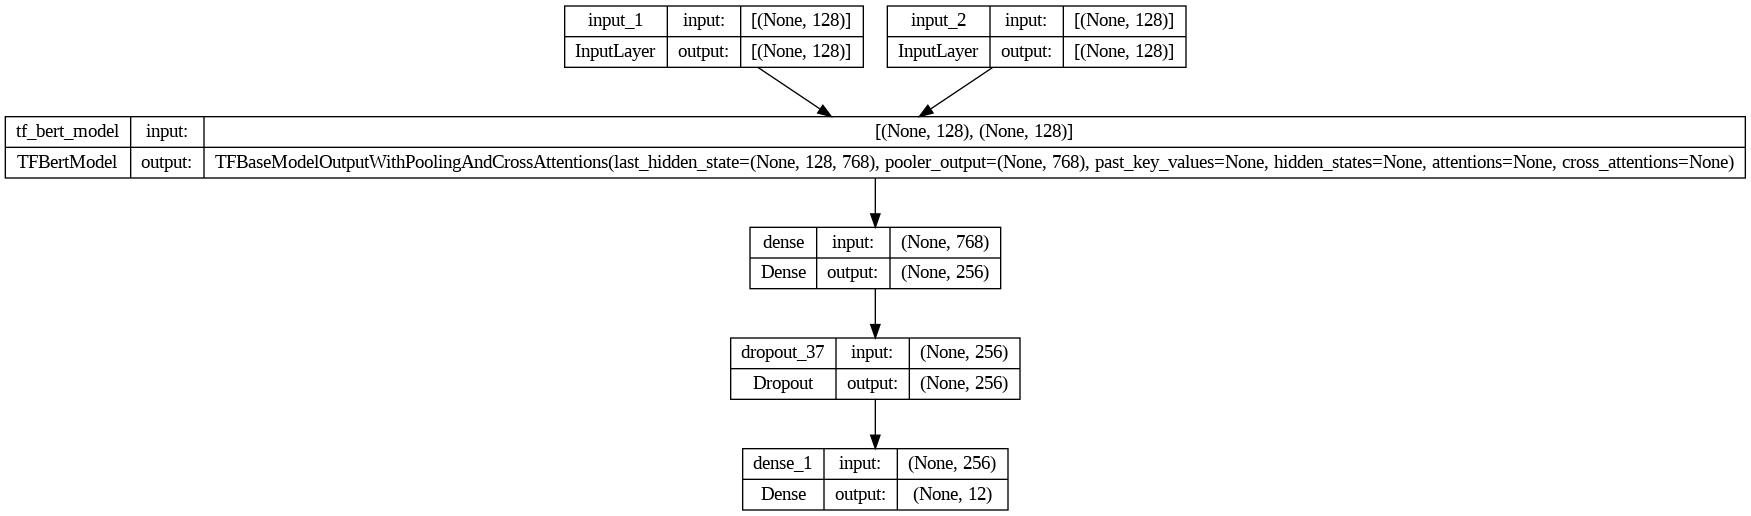

In [39]:
from PIL import Image

# Visualiza la arquitectura del modelo y guarda la imagen
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Muestra la imagen en la pantalla
img = Image.open('model.png')
img.show()

### 3.2 Entrenar modelo

In [40]:
# ajustar el transformador BERT
history_bert = model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_val), epochs=7, batch_size=32)

Epoch 1/7
881/881 [==============================] - 312s 302ms/step - loss: 2.0303 - categorical_accuracy: 0.2964 - val_loss: 1.7951 - val_categorical_accuracy: 0.3746
Epoch 2/7
881/881 [==============================] - 252s 286ms/step - loss: 1.8304 - categorical_accuracy: 0.3786 - val_loss: 1.7632 - val_categorical_accuracy: 0.3840
Epoch 3/7
881/881 [==============================] - 252s 286ms/step - loss: 1.7507 - categorical_accuracy: 0.4045 - val_loss: 1.7591 - val_categorical_accuracy: 0.3858
Epoch 4/7
881/881 [==============================] - 251s 285ms/step - loss: 1.6616 - categorical_accuracy: 0.4366 - val_loss: 1.7746 - val_categorical_accuracy: 0.3901
Epoch 5/7
881/881 [==============================] - 251s 285ms/step - loss: 1.5444 - categorical_accuracy: 0.4822 - val_loss: 1.8346 - val_categorical_accuracy: 0.3786
Epoch 6/7
881/881 [==============================] - 251s 285ms/step - loss: 1.4104 - categorical_accuracy: 0.5315 - val_loss: 1.9579 - val_categorical_acc

* **Precisión y la pérdida a lo largo del tiempo**

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


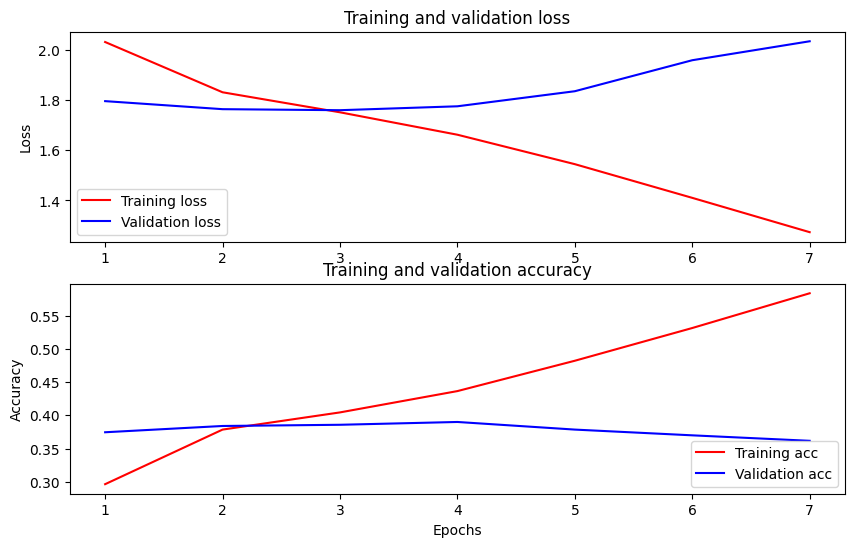

In [41]:
history_dict = history_bert.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 3.4. Predecir y evaluar el modelo 

In [42]:
result_bert = model.predict([test_input_ids,test_attention_masks])

183/183 [==============================] - 21s 98ms/step


In [43]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

<Axes: >

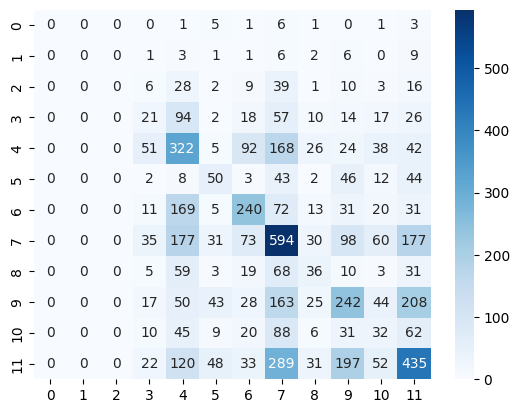

In [44]:
labels = np.unique(y_test.argmax(1))
cm = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1), labels=labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

* **Evaluación del modelo**

In [45]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['anger', 'boredom', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral',
                                                                                                      'relief', 'sadness', 'surprise', 'worry']))

	Classification Report for BERT:

               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        18
     boredom       0.00      0.00      0.00        29
  enthusiasm       0.00      0.00      0.00       114
         fun       0.12      0.08      0.10       259
   happiness       0.30      0.42      0.35       768
        hate       0.25      0.24      0.24       210
        love       0.45      0.41      0.43       592
     neutral       0.37      0.47      0.41      1275
      relief       0.20      0.15      0.17       234
     sadness       0.34      0.30      0.32       820
    surprise       0.11      0.11      0.11       303
       worry       0.40      0.35      0.38      1227

   micro avg       0.34      0.34      0.34      5849
   macro avg       0.21      0.21      0.21      5849
weighted avg       0.33      0.34      0.33      5849
 samples avg       0.34      0.34      0.34      5849



## 4. Observaciones generales

Algunas observaciones que pueden extraerse de los resultados del modelo BERT son:
* Rendimiento del modelo: El modelo entrenado logró una precisión global de 34% en la clasificación de las 12 emociones. Aunque esto no es un rendimiento muy alto, considerando que la mayoría de las emociones son difíciles de detectar incluso para los humanos, el modelo puede ser útil como herramienta de apoyo para la detección de emociones.

* Desempeño de las emociones: Al examinar las métricas de precisión, recall y f1-score para cada emoción, se puede observar que el modelo tuvo un rendimiento razonable en algunas emociones, como "love" y "happiness", pero tuvo un rendimiento bastante pobre en otras, como "anger" y "boredom". Esto puede indicar que ciertas emociones son más difíciles de detectar que otras, y que puede ser necesario ajustar el modelo para mejorar su rendimiento en estas emociones.

* Desafíos en la detección de emociones: La baja precisión y recall para ciertas emociones sugiere que la detección de emociones es un desafío complejo en el procesamiento de lenguaje natural. La ambigüedad en el uso del lenguaje humano, la variabilidad en la expresión emocional y la falta de contexto pueden ser algunos de los desafíos en la detección precisa de emociones.

* Gráfico de pérdida y precisión en el conjunto de entrenamiento y validación: Este gráfico muestra la pérdida y la precisión del modelo en los conjuntos de entrenamiento y validación en cada época. Se observa que la pérdida disminuye y la precisión aumenta con cada época tanto en el conjunto de entrenamiento como en el de validación, lo que indica que el modelo está aprendiendo y mejorando.

* Matriz de confusión: La matriz de confusión proporciona una vista detallada del rendimiento del modelo en cada clase. Se observa que el modelo tiene un rendimiento bajo en la mayoría de las clases, especialmente en "anger", "boredom", y "enthusiasm". Sin embargo, el modelo tiene un mejor rendimiento en las clases de "love", "neutral" y "worry".


En resumen, aunque el modelo de procesamiento de lenguaje natural entrenado con la arquitectura BERT tuvo un rendimiento moderado en la clasificación de emociones, la detección de emociones sigue siendo un desafío complejo. El modelo puede ser útil como herramienta de apoyo para la detección de emociones, pero se deben explorar más mejoras y ajustes para mejorar su rendimiento.
